In [272]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import descartes
import shapely.geometry as sg
from shapely.ops import cascaded_union
from itertools import combinations
from functools import reduce

In [187]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

### Задание 0. Классы

In [377]:
class Point:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def draw(self, **kwargs):
        ax = plt.gca()
        plt.axis('equal')
        plt.axis('off')
        ax.plot(self.x, self.y,  '.', **kwargs)
    
    def get_pos(self):
        return self.x, self.y
    
class Shape(Point):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def draw(self, **kwargs):
        ax = plt.gca()
        plt.axis('equal')
        
        ax.plot(self.x, self.y, 'x', **kwargs)
        
    def is_inside(self, point):
        x, y = point.get_pos()
        return (self.x, self.y) == (x, y)
    
    
class Circle(Shape):
    
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def draw(self, **kwargs):
        ax = plt.gca()
        circle = mpatches.Circle((self.x, self.y), self.r, **kwargs)
        ax.add_patch(circle)
        plt.axis('equal')
        plt.axis('off')
        
    def is_inside(self, point):
        x, y = point.get_pos()
        return ((x - self.x)**2 + (y - self.y)**2) <= (self.r)**2
    
    def shapely_object(self):
        return sg.Point(self.x, self.y).buffer(self.r)
    

class Square(Shape):
    
    def __init__(self, x, y, a):
        self.x = x
        self.y = y
        self.a = a
    
    def draw(self, **kwargs):
        ax = plt.gca()
        square = mpatches.Rectangle((self.x, self.y), self.a, self.a, **kwargs)
        ax.add_patch(square)
        plt.axis('equal')
        plt.axis('off')
        
    def is_inside(self, point):
        x, y = point.get_pos()
        return all([x >= self.x, y >= self.y, x - self.x <= self.a, y - self.y <= self.a])
    
    def shapely_object(self):
        return sg.box(self.x, self.y, self.x + self.a, self.y + self.a)


class Union(Shape):
    
    def __init__(self, shapes):
        self.shapes = shapes
    
    def draw(self, **kwargs):
        for shape in self.shapes:
            shape.draw(**kwargs)
    
    def is_inside(self, point):
        x, y = point.get_pos()
        return any([shape.is_inside(x, y) for shape in self.shapes])
    
    def shapely_object(self):
        objs = [shape.shapely_object() for shape in self.shapes]
        res = reduce(lambda prev, cur: prev.intersection(cur), objs)
        return cascaded_union([shape.shapely_object() for shape in self.shapes])

class Intersect(Shape):
    
    def __init__(self, shapes):
        self.shapes = shapes
        
    def draw(self, **kwargs):
        ax = plt.gca()
        shape = self.shapely_object()
        
        if not shape.is_empty:
            if shape.type == 'GeometryCollection':
                for obj in shape:
                    if obj.type == 'Point':
                        Point(obj.x, obj.y).draw(**kwargs)
                    else:
                        ax.add_patch(descartes.PolygonPatch(obj, **kwargs)) 
            else:
                ax.add_patch(descartes.PolygonPatch(shape, **kwargs)) 
                
        plt.axis('equal')
        plt.axis('off')
        
    def is_inside(self, point):
        x, y = point.get_pos()
        return all([shape.is_inside(x, y) for shape in self.shapes])
        
    def shapely_object(self):
        objs = [shape.shapely_object() for shape in self.shapes]
        return reduce(lambda prev, cur: prev.intersection(cur), objs)
    
    

True False False False


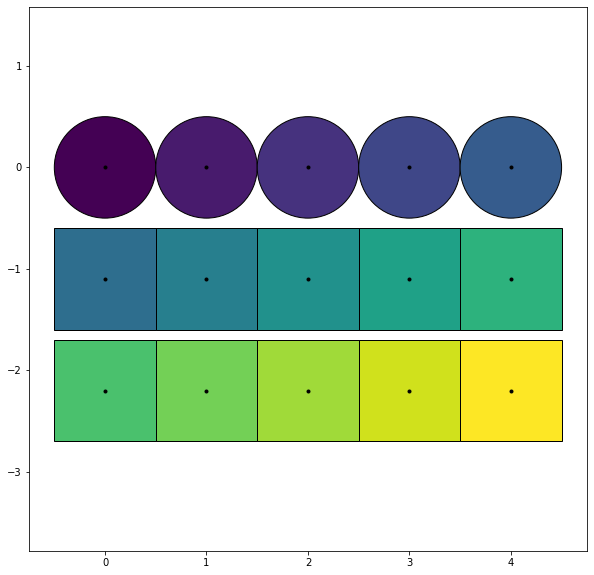

In [396]:
plt.figure(figsize=(10, 10))

circles = [Circle(x, 0, 0.5) for x in np.arange(0, 5, 1)]

squares = [Square(x, y, 1) for y in (-1.6, -2.7) for x in np.arange(-0.5, 4.5, 1)]

points = [Point(x, y) for x in np.arange(0, 5, 1) for y in (0, -1.1, -2.2)]

cmap = plt.cm.get_cmap('viridis', len(circles + squares))

for i, shape in enumerate(circles + squares):
    shape.draw(facecolor = cmap(i), edgecolor='k')

for point in points:
    point.draw(color='k')
    
plt.axis('on')

print(circles[0].is_inside(points[0]), 
      circles[0].is_inside(points[1]),
      squares[2].is_inside(points[2]),
      squares[2].is_inside(points[0]))

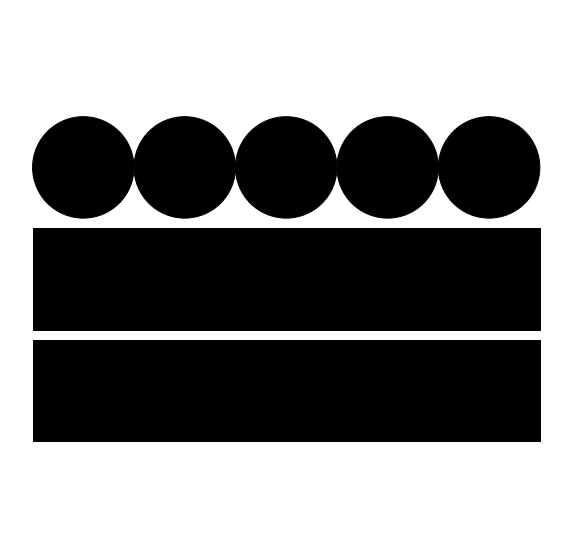

In [391]:
plt.figure(figsize=(10, 10))

circles = [Circle(x, 0, 0.5) for x in np.arange(0, 5, 1)]
squares = [Square(x, y, 1) for x in np.arange(-0.5, 4.5, 1) for y in (-1.6, -2.7)]

union = Union(circles + squares)
intersection = Intersect(circles + squares)

union.draw(color='black')

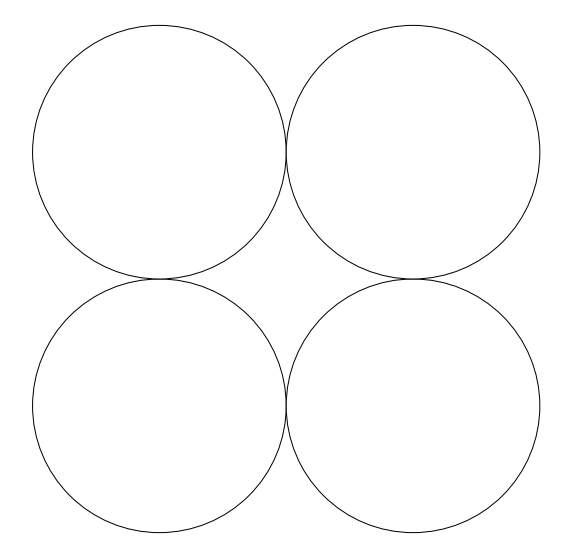

In [385]:
plt.figure(figsize=(10, 10))

circles = [Circle(x, y, 0.5) for x in (0, 1) for y in (0, 1)]

square = Square(0, 0, 1)

for circle in circles:
    circle.draw(facecolor='white', edgecolor='black')

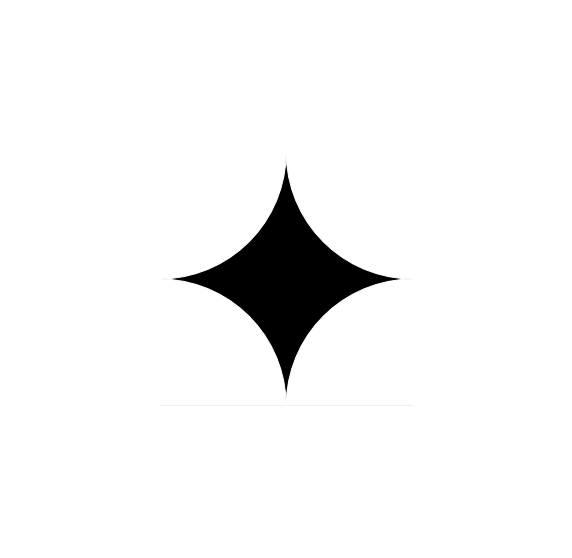

In [388]:
plt.figure(figsize=(10, 10))

circles = [Circle(x, y, 0.5) for x in (0, 1) for y in (0, 1)]

square = Square(0, 0, 1)

for circle in circles:
    circle.draw(color='white')

square.draw(facecolor='black', edgecolor='white')

intersection = Intersect([Union(circles), square])
intersection.draw(color='white')

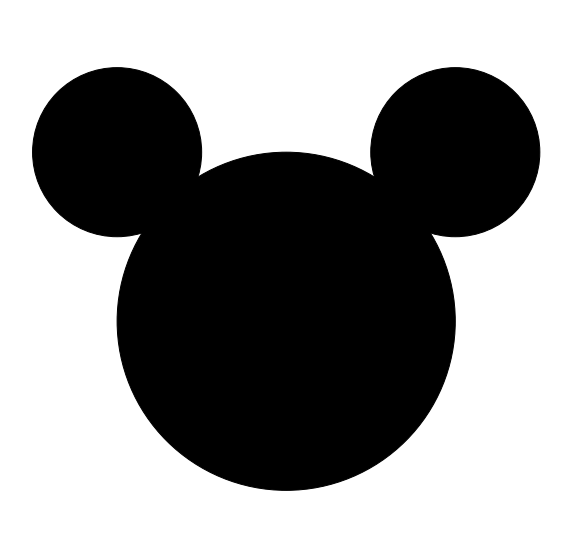

In [201]:
plt.figure(figsize=(10, 10))
hidden_mickey = Union([Circle(0, 0, 2), Circle(2, 2, 1), Circle(-2, 2, 1)])
hidden_mickey.draw(color='black')

### Задание 1. Декораторы

In [448]:
def logger(func):
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except BaseException as exception:
            with open('log.txt', 'a') as log:
                log.write(repr(exception))
                log.write('\n')
    return wrapper


In [449]:
@logger
def f(exception, *args):
    raise exception(*args)

In [450]:
f(ZeroDivisionError, '1 / 0')

In [451]:
f(ValueError, "В функцию передано некорректное значение")

In [452]:
f(TypeError, "Тип аргумента функции не поддерживается")